# Hands-on

## Points

```{important}
This is an adapted version, with a bit less content and detail, of the chapter on points by Rey, Arribas-Bel and Wolf (*in progress*) {cite}`reyABwolf`. Check out the full chapter, available for free at:

> [https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html](https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html)
```


Points are spatial entities that can be understood in two fundamentally different ways. On the one hand, points can be seen as fixed objects in space, which is to say their location is taken as given (*exogenous*). In this case, analysis of points is very similar to that of other types of spatial data such as polygons and lines. On the other hand, points can be seen as the occurence of an event that could theoretically take place anywhere but only manifests in certain locations. This is the approach we will adopt in the rest of the notebook.

When points are seen as events that could take place in several locations but only happen in a few of them, a collection of such events is called a *point pattern*. In this case, the location of points is one of the key aspects of interest for analysis. A good example of a point pattern is crime events in a city: they could technically happen in many locations but we usually find crimes are committed only in a handful of them. Point patterns can be *marked*, if more attributes are provided with the location, or *unmarked*, if only the coordinates of where the event occured are provided. Continuing the crime example, an unmarked pattern would result if only the location where crimes were committed was used for analysis, while we would be speaking of a marked point pattern if other attributes, such as the type of crime, the extent of the damage, etc. was provided with the location.

Point pattern analysis is thus concerned with the description, statistical characerization, and modeling of point patterns, focusing specially on the generating process that gives rise and explains the observed data. *What's the nature of the distribution of points?* *Is there any structure we can statistically discern in the way locations are arranged over space?* *Why do events occur in those places and not in others?* These are all questions that point pattern analysis is concerned with.

This notebook aims to be a gentle introduction to working with point patterns in Python. As such, it covers how to read, process and transform point data, as well as several common ways to visualize point patterns.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from ipywidgets import interact, fixed

## Data

### Photographs

```{margin}
You can read more about the dataset on [its page at the GDS Book](https://geographicdata.science/book/data/tokyo/tokyo_cleaning.html) website
```

We are going to dip our toes in the lake of point data by looking at a sample of geo-referenced photographs in Tokyo. The dataset comes from the GDS Book {cite}`reyABwolf` and contains photographs voluntarily uploaded to the Flickr service.

Let's read the dataset first:

````{margin}
```{admonition} Important
Make sure you are connected to the internet when you run this cell
```
````

In [2]:
# Read remote file
tokyo = pd.read_csv(
    "https://geographicdata.science/book/_downloads/7fb86b605af15b3c9cbd9bfcbead23e9/tokyo_clean.csv"
)

````{admonition} Alternative
Instead of reading the file directly off the web, it is possible to download it manually, store it on your computer, and read it locally. To do that, you can follow these steps:
1. Download the file by right-clicking on [this link](https://geographicdata.science/book/_downloads/7fb86b605af15b3c9cbd9bfcbead23e9/tokyo_clean.csv) and saving the file
1. Place the file on the _same folder as the notebook_ where you intend to read it
1. Replace the code in the cell above by:
```python
tokyo = pd.read_csv("tokyo_clean.csv")
```
````

### Administrative areas

We will later use administrative areas for aggregation. Let's load them upfront first. These are provided with the course and available online:

````{margin}
```{admonition} Important
Make sure you are connected to the internet when you run this cell
```
````

In [3]:
# Read the file in
areas = gpd.read_file(
    "https://darribas.org/gds_course/content/data/tokyo_admin_boundaries.geojson"
)

````{admonition} Alternative
Instead of reading the file directly off the web, it is possible to download it manually, store it on your computer, and read it locally. To do that, you can follow these steps:
1. Download the file by right-clicking on [this link](../data/tokyo_admin_boundaries.geojson) and saving the file
1. Place the file on the _same folder as the notebook_ where you intend to read it
1. Replace the code in the cell above by:
```python
areas = gpd.read_file("tokyo_admin_boundaries.geojson")
```
````

The final bit we need to get out of the way is attaching the administrative area code where a photo is located to each area. This can be done with a GIS operation called "spatial join". 

```{margin}
Click the cell below if you are interested in finding out how it works. In the interest of the narrative of this section, we present it collapsed
```

In [4]:
tokyo_gdf = gpd.GeoDataFrame(
    {
        "geometry": gpd.points_from_xy(
            tokyo["longitude"], tokyo["latitude"]
        )
    }, crs="EPSG:4326"
).join(tokyo)
crosswalk = gpd.sjoin(tokyo_gdf, areas, how="inner")
tokyo["admin_area"] = crosswalk["GID_2"]

Now we are good to go!

## Visualization of a Point Pattern

We will spend the rest of this notebook learning different ways to visualize a point pattern. In particular, we will consider to main strategies: one relies on aggregating the points into polygons, while the second one is based on creating continuous surfaces using kernel density estimation.

### One-to-one

The first approach we review here is the one-to-one approach, where we place a dot on the screen for every point to visualise. In Python, one way to do this is with the `scatter` method in the Pandas visualisation layer:

<Axes: xlabel='longitude', ylabel='latitude'>

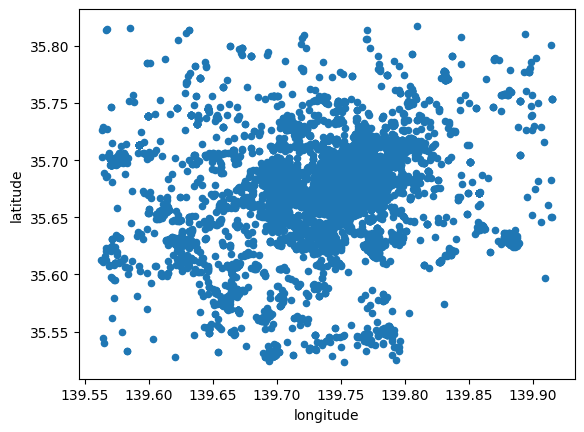

In [10]:
# Plot a dot for every image
tokyo.plot.scatter("longitude", "latitude")

However this does not give us much geographical context and, since there are many points, it is hard to see any pattern in areas of high density. Let's tweak the dot display and add a basemap:

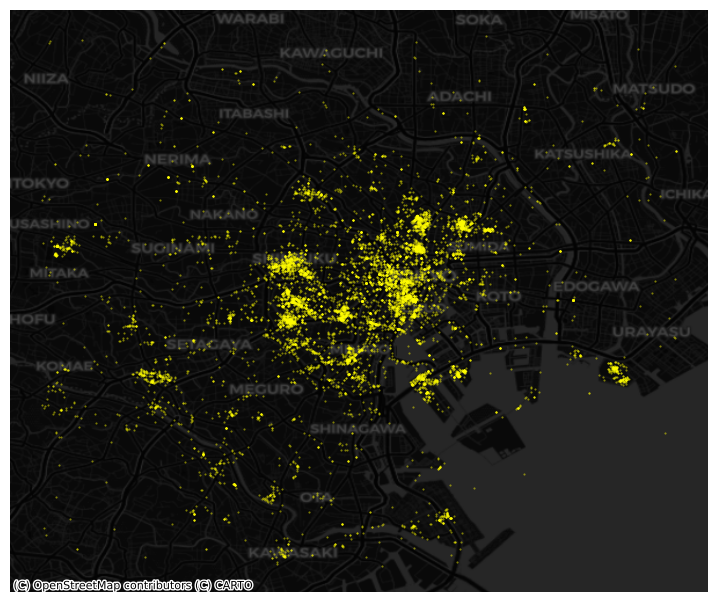

In [11]:
# Plot photographs with smaller, more translucent dots
ax = tokyo.plot.scatter(
    "longitude", 
    "latitude",
    s=0.25,
    c="xkcd:bright yellow",
    alpha=0.5,
    figsize=(9, 9)
)
# remove axis
ax.set_axis_off()
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatter
)

### Points meet polygons

The approach presented above works until a certain number of points to plot; tweaking dot transparency and size only gets us so far and, at some point, we need to shift the focus. Having learned about visualizing lattice (polygon) data, an option is to "turn" points into polygons and apply techniques like choropleth mapping to visualize their spatial distribution. To do that, we will overlay a polygon layer on top of the point pattern, *join* the points to the polygons by assigning to each point the polygon where they fall into, and create a choropleth of the counts by polygon. 

This approach is intuitive but of course raises the following question: *what polygons do we use to aggregate the points?* Ideally, we want a boundary delineation that matches as closely as possible the point generating process and partitions the space into areas with a similar internal intensity of points. However, that is usually not the case, no less because one of the main reasons we typically want to visualize the point pattern is to learn about such generating process, so we would typically not know a priori whether a set of polygons match it. If we cannot count on the ideal set of polygons to begin with, we can adopt two more realistic approaches: using a set of pre-existing irregular areas or create a artificial set of regular polygons. Let's explore both.

#### Irregular lattices

To exemplify this approach, we will use the administrative areas we have loaded above. Let's add them to the figure above to get better context (unfold the code if you are interested in seeing exactly how we do this):

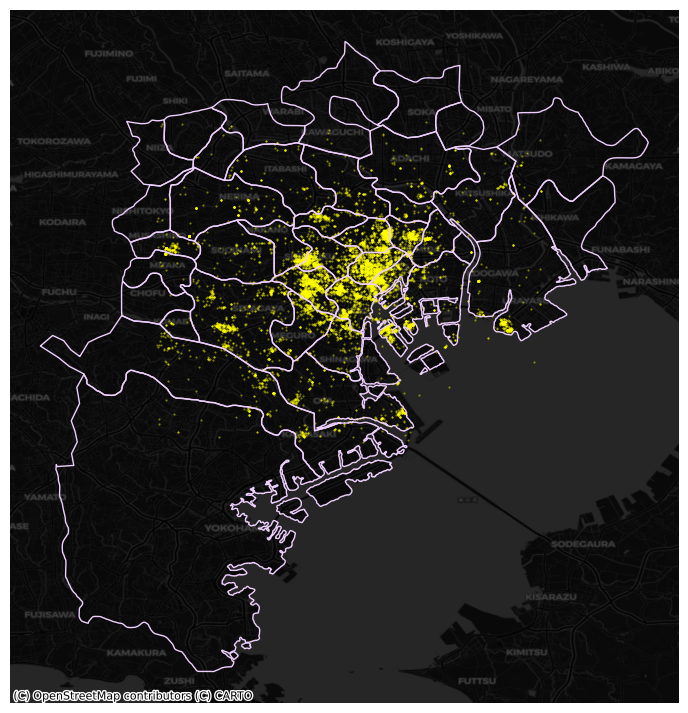

In [13]:
# Plot photographs with smaller, more translucent dots
ax = tokyo.plot.scatter(
    "longitude", 
    "latitude",
    s=0.25,
    c="xkcd:bright yellow",
    alpha=0.5,
    figsize=(9, 9)
)
# Add administrative boundaries
areas.plot(
    ax=ax,
    facecolor="none",
    edgecolor="xkcd:pale lavender"
)
# remove axis
ax.set_axis_off()
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatter
)

Now we need to know how many photographs each are contains. Our photograph table already contains the area ID, so all we need to do here is counting by area and attaching the count to the `areas` table. We rely here on the `groupby` operator which takes all the photos in the table and "groups" them "by" their administrative ID. Once grouped, we apply the method `size`, which counts how many elements each group has and returns a column indexed on the LSOA code with all the counts as its values. We end by assigning the counts to a newly created column in the `areas` table.

In [15]:
# Create counts
photos_by_area = tokyo.groupby("admin_area").size()
# Assign counts into a table of its own 
# and joins it to the areas table
areas = areas.join(
    pd.DataFrame({"photo_count": photos_by_area}),
    on="GID_2"
)

The lines above have created a new column in our `areas` table that contains the number of photos that have been taken within each of the polygons in the table.

````{margin}
```{Tip}
Check out [Block D](../bD/concepts) if you need a refresher of choropleth maps
```
````

At this point, we are ready to map the counts. Technically speaking, this is a choropleth just as we have seen many times before:

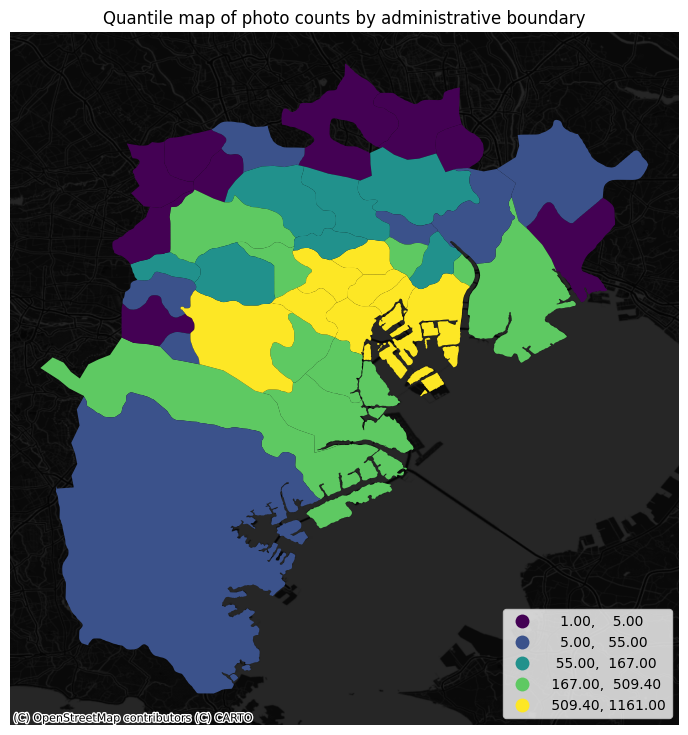

In [63]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot the equal interval choropleth and add a legend
areas.plot(
    column='photo_count', 
    scheme='quantiles', 
    ax=ax,
    legend=True,
    legend_kwds={"loc": 4}
)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Quantile map of photo counts by administrative boundary")
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Draw map
plt.show()

The map above clearly shows a concentration of photos in the centre of Tokyo. However, it is important to remember that the map is showing *raw* counts of tweets. In the case to photos, as with many other phenomena, it is crucial to keep in mind the "container geography" (see [Block D](../bD/concepts_D) for a refresher of the term). In this case, different administrative areas have different sizes. Everything else equal, a larger polygon may contain more photos, simply because it covers a larger space. To obtain a more accurate picture of the _intensity_ of photos by area, what we would like to see is a map of the *density* of photos, not of raw counts. To do this, we can divide the count per polygon by the area of the polygon.

Let's first calculate the area in Sq. metres of each administrative delineation:

```{margin}
Note how we need to convert our polygons into a projected CRS. Same as we did with the {ref}`Japanese functional urban areas <diy_E:jp_cities>`, we use the [Japan Plane Rectangular CS XVII system](http://epsg.io/2459)

Also, we multiply the area by `1e-6` to express the area in squared Km instead of sq. metres
```

In [23]:
areas["area_sqkm"] = areas.to_crs(epsg=2459).area * 1e-6

And we can add the photo density as well:

In [25]:
areas["photo_density"] = areas["photo_count"] / areas["area_sqkm"]

With the density at hand, creating the new choropleth is similar as above (check the code in the expandable):

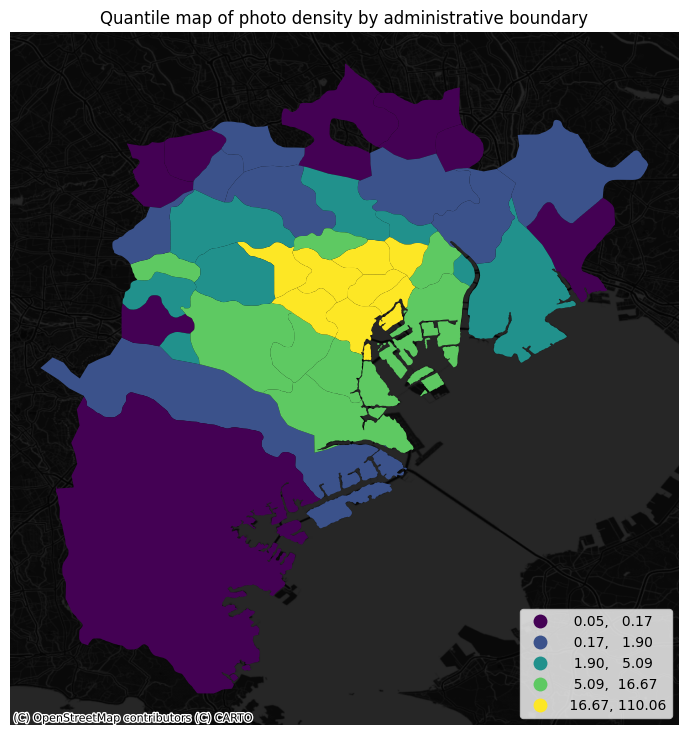

In [26]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot the equal interval choropleth and add a legend
areas.plot(
    column='photo_density', 
    scheme='quantiles', 
    ax=ax,
    legend=True,
    legend_kwds={"loc": 4}
)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Quantile map of photo density by administrative boundary")
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Draw map
plt.show()

The pattern in the raw counts is similar to that of density, but we can see how some peripheral, large areas are "downgraded" when correcting for their size, while some smaller polygons in the centre display a higher value.

#### Regular lattices: hex-binning

Sometimes we either do not have any polygon layer to use or the ones we have are not particularly well suited to aggregate points into them. In these cases, a sensible alternative is to create an artificial topology of polygons that we can use to aggregate points. There are several ways to do this but the most common one is to create a grid of hexagons. This provides a regular topology (every polygon is of the same size and shape) that, unlike circles, cleanly exhausts all the space without overlaps and has more edges than squares, which alleviates edge problems.

Python has a simplified way to create this hexagon layer *and* aggregate points into it in one shot thanks to the method `hexbin`, which is available in every axis object (e.g. `ax`). Let us first see how you could create a map of the hexagon layer alone:

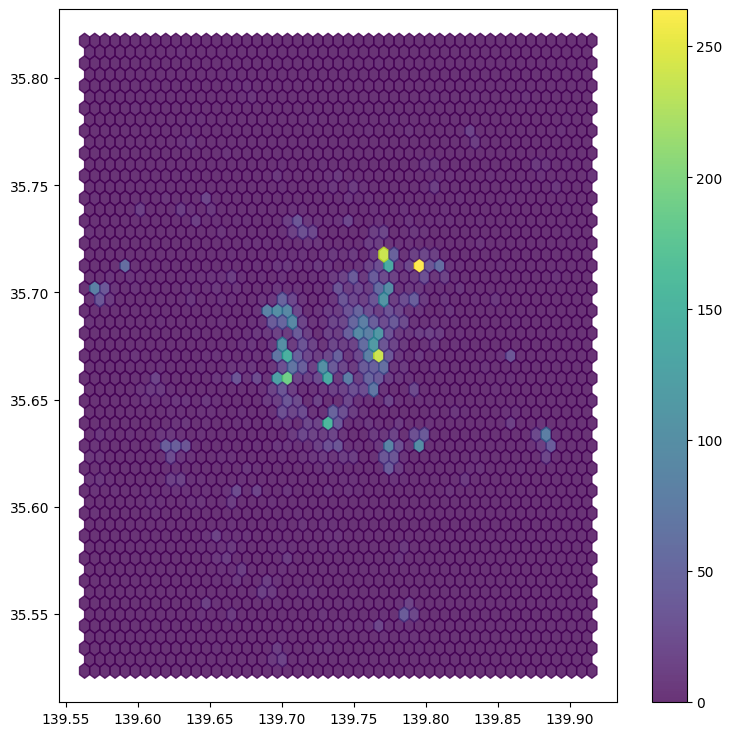

In [35]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(
    tokyo["longitude"], 
    tokyo["latitude"], 
    gridsize=50, 
    alpha=0.8
)
# Add a colorbar (optional)
plt.colorbar(hb)

See how all it takes is to set up the figure and call `hexbin` directly using the set of coordinate columns (`tokyo["longitude"]` and `tokyo["latitude"]`). Additional arguments we include is the number of hexagons by axis (`gridsize`, 50 for a 50 by 50 layer), and the transparency we want (80%). Additionally, we include a colorbar to get a sense of how counts are mapped to colors. Note that we need to pass the name of the object that includes the `hexbin` (`hb` in our case), but keep in mind this is optional, you do not need to always create one.

Once we know the basics, we can dress it up a bit more for better results (expand to see code):

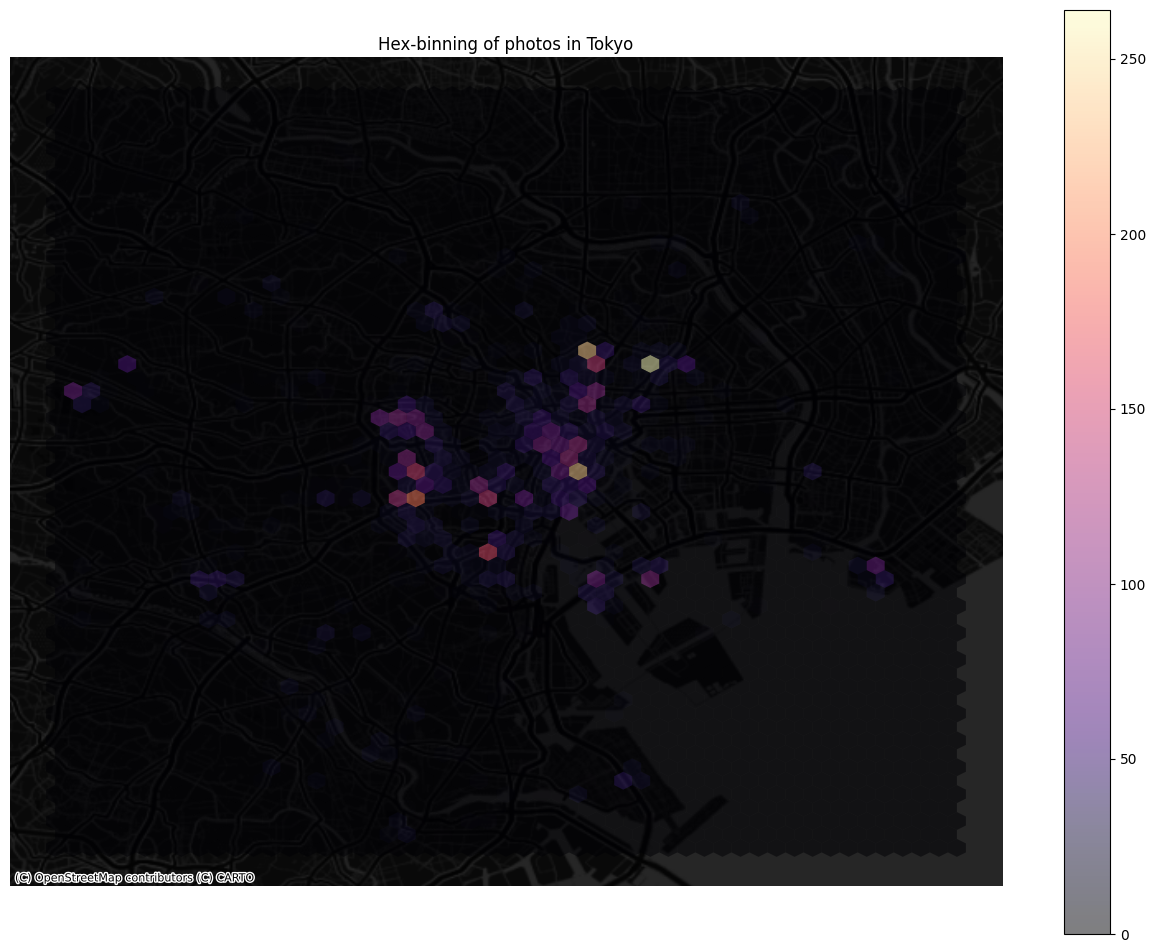

In [61]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(16, 12))
# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(
    tokyo["longitude"], 
    tokyo["latitude"], 
    gridsize=50,
    alpha=0.5,
    edgecolor="none",
    cmap='magma'
)
# Add a colorbar (optional)
plt.colorbar(hb)
# Remove axis
ax.set_axis_off()
# Add basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax.set_title("Hex-binning of photos in Tokyo")
# Draw map
plt.show()

### Kernel Density Estimation


Using a hexagonal binning can be a quick solution when we do not have a good polygon layer to overlay the points directly and some of its properties, such as the equal size of each polygon, can help alleviate some of the problems with a "bad" irregular topology (one that does not fit the underlying point generating process). However, it does not get around the issue of the modifiable areal unit problem (M.A.U.P., see [Block D](../bD/concepts_D): at the end of the day, we are still imposing arbitrary boundary lines and aggregating based on them, so the possibility of mismatch with the underlying distribution of the point pattern is very real.

One way to work around this problem is to avoid aggregating into another geography altogether. Instead, we can aim at estimating the *continuous* observed probability distribution. The most commonly used method to do this is the so called *kernel density estimate* (KDE). The idea behind KDEs is to count the number of points in a *continious* way. Instead of using discrete counting, where you include a point in the count if it is inside a certain boundary and ignore it otherwise, KDEs use functions (kernels) that include points but give different weights to each one depending of how far of the location where we are counting the point is.

The actual algorithm to estimate a kernel density is not trivial but its application in Python is rather simplified by the use of Seaborn. KDE's however are fairly computationally intensive. When you have a large point pattern like we do in the `tokyo` example (10,000 points), its computation can take a bit long. To get around this issue, we create a random subset, which retains the overall structure of the pattern, but with much fewer points. Let's take a subset of 1,000 random points from our original table: 

In [37]:
# Take a random subset of 1,000 rows from `tokyo`
tokyo_sub = tokyo.sample(1000, random_state=12345)

Note we need to specify the size of the resulting subset (1,000), and we also add a value for `random_state`; this ensures that the sample is always the same and results are thus reproducible.

Same as above, let us first see how to create a quick KDE. For this we rely on Seaborn's `kdeplot`:

<Axes: xlabel='longitude', ylabel='latitude'>

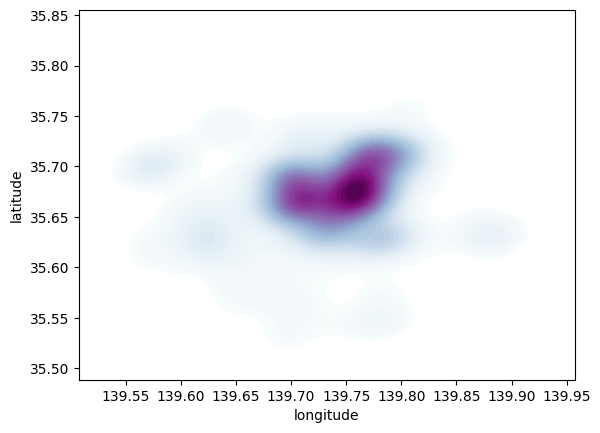

In [45]:
sns.kdeplot(
    x="longitude", 
    y="latitude",
    data=tokyo_sub,
    n_levels=50, 
    fill=True, 
    cmap='BuPu'
)

Seaborn greatly streamlines the process and boils it down to a single line. The method `sns.kdeplot` (which we can also use to create a KDE of a single variable) takes the X and Y coordinate of the points as the only compulsory attributes. In addition, we specify the number of levels we want the color gradient to have (`n_levels`), whether we want to color the space in between each level (`share` (or now `fill`?), yes), and the colormap of choice.

Once we know how the basic logic works, we can insert it into the usual mapping machinery to create a more complete plot. The main difference here is that we now have to tell `sns.kdeplot` where we want the surface to be added (`ax` in this case). Toggle the expandable to find out the code that produces the figure below:

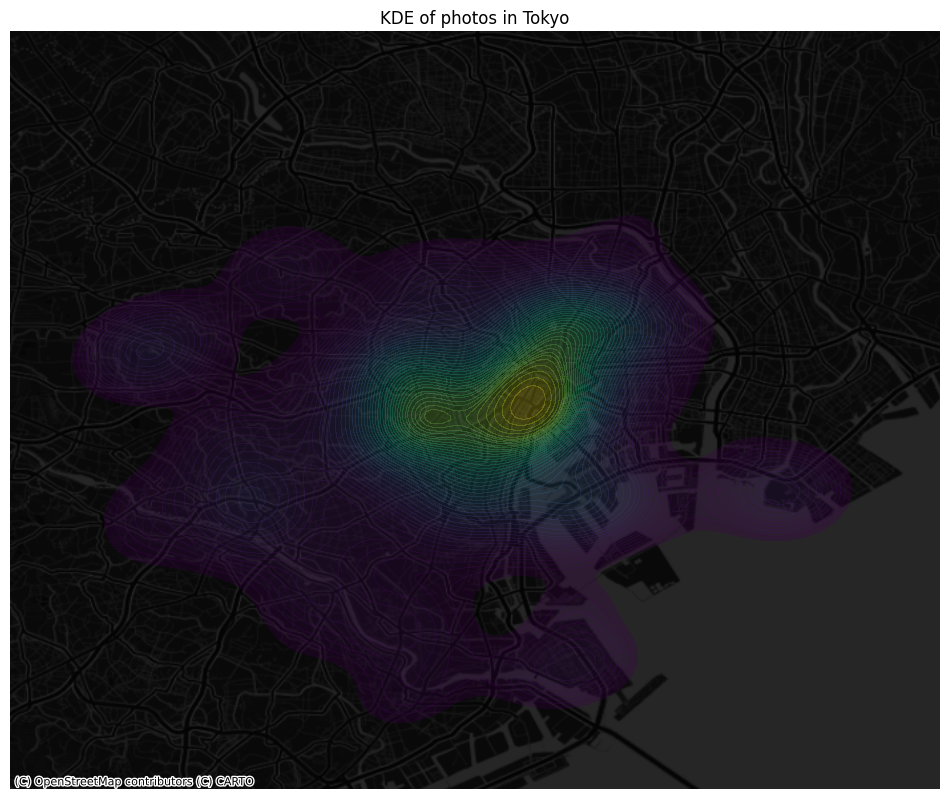

In [47]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Add KDE layer that displays probability surface
sns.kdeplot(
    x='longitude', 
    y='latitude', 
    data=tokyo_sub,
    n_levels=50, 
    fill=True,
    alpha=0.25,
    cmap="viridis",
    ax=ax
)
# Remove axis
ax.set_axis_off()
# Add basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax.set_title("KDE of photos in Tokyo")
# Draw map
plt.show()

## Clusters of points

In this final section, we will learn a method to identify clusters of points, based on their density across space. To do this, we will use the widely used `DBSCAN` algorithm. For this method, a cluster is a concentration of at least `m` points, each of them within a distance of `r` of at least another point in the cluster. Points in the dataset are then divided into three categories:

* *Noise*, for those points outside a cluster.
* *Cores*, for those points inside a cluster whith at least `m` points in the cluster within distance `r`.
* *Borders* for points inside a cluster with less than `m` other points in the cluster within distance `r`.

Both `m` and `r` need to be prespecified by the user before running `DBSCAN`. This is a critical point, as their value can influence significantly the final result. Before exploring this in greater depth, let us get a first run at computing `DBSCAN` in Python.

### Basics

The heavy lifting is done by the method `DBSCAN`, part of the excellent machine learning library `scikit-learn`. Running the algorithm is similar to how we ran K-Means when [clustering](../bG/lab_G). We first set up the details:

In [48]:
# Set up algorithm
algo = DBSCAN(eps=100, min_samples=50)

In [49]:
## Express points in metres
# Convert lon/lat into Point objects + set CRS
pts = gpd.points_from_xy(
    tokyo["longitude"],
    tokyo["latitude"],
    crs="EPSG:4326"
)
# Convert lon/lat points to Japanese CRS in metres
pts = gpd.GeoDataFrame({"geometry": pts}).to_crs(epsg=2459)
# Extract coordinates from point objects into columns
tokyo["X_metres"] = pts.geometry.x
tokyo["Y_metres"] = pts.geometry.y

We decide to consider a cluster photos with more than 50 photos within 100 metres from them, hence we set the two parameters accordingly. Once ready, we _"fit"_ it to our data, but note that we first need to express the longitude and latitude of our points in metres (see code for that on the side cell).

In [50]:
algo.fit(tokyo[["X_metres", "Y_metres"]])

DBSCAN(eps=100, min_samples=50)

Once fit, we can recover the labels:

In [51]:
algo.labels_

array([-1, -1, -1, ...,  8, -1, -1])

And the list of points classified as cores:

In [52]:
# Print only the first five values
algo.core_sample_indices_[:5]

array([12, 25, 28, 46, 63])

The `labels_` object always has the same length as the number of points used to run `DBSCAN`. Each value represents the index of the cluster a point belongs to. If the point is classified as *noise*, it receives a -1. Above, we can see that the first five points are effectively not part of any cluster. To make thinks easier later on, let us turn the labels into a `Series` object that we can index in the same way as our collection of points:

In [53]:
lbls = pd.Series(algo.labels_, index=tokyo.index)

Now we already have the clusters, we can proceed to visualize them. There are many ways in which this can be done. We will start just by coloring points in a cluster in red and noise in grey:

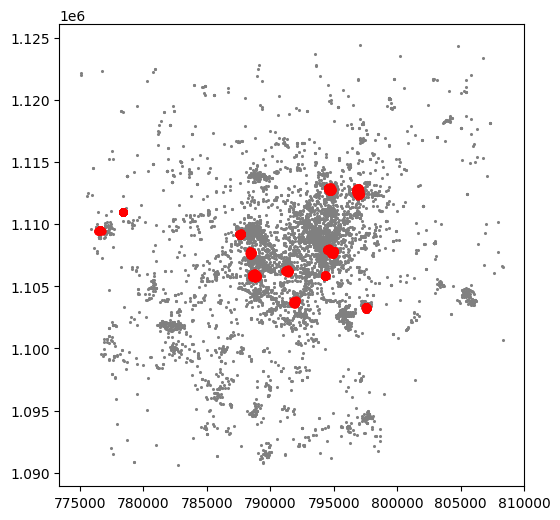

In [54]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Assign labels to tokyo table dynamically and
# subset points that are not part of any cluster (noise)
noise = tokyo.assign(
    lbls=lbls
).query("lbls == -1")
# Plot noise in grey
ax.scatter(
    x=noise["X_metres"], 
    y=noise["Y_metres"], 
    c='grey', 
    s=5, 
    linewidth=0
)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    tokyo.loc[tokyo.index.difference(noise.index), "X_metres"], 
    tokyo.loc[tokyo.index.difference(noise.index), "Y_metres"],
    c="red", 
    linewidth=0
)
# Display the figure
plt.show()

This is a first good pass. The algorithm is able to identify a few clusters with high density of photos. However, as we mentioned {ref}`when discussing DBSCAN <concepts_H:dbscan>`, this is all contingent on the parameters we arbitrarily set. Depending on the maximum radious (`eps`) we set, we will pick one type of cluster or another: a higher (lower) radious will translate in less (more) local clusters. Equally, the minimum number of points required for a cluster (`min_samples`) will affect the implicit size of the cluster. Both parameters need to be set before running the algorithm, so our decision will affect the final outcome quite significantly.

For an illustration of this, let's run through a case with very different parameter values. For example, let's pick a larger radious (e.g. 500m) and a smaller number of points (e.g. 10):

In [55]:
# Set up algorithm
algo = DBSCAN(eps=500, min_samples=10)
# Fit to Tokyo projected points
algo.fit(tokyo[["X_metres", "Y_metres"]])
# Store labels
lbls = pd.Series(algo.labels_, index=tokyo.index)

And let's now visualise the result (toggle the expandable to see the code):

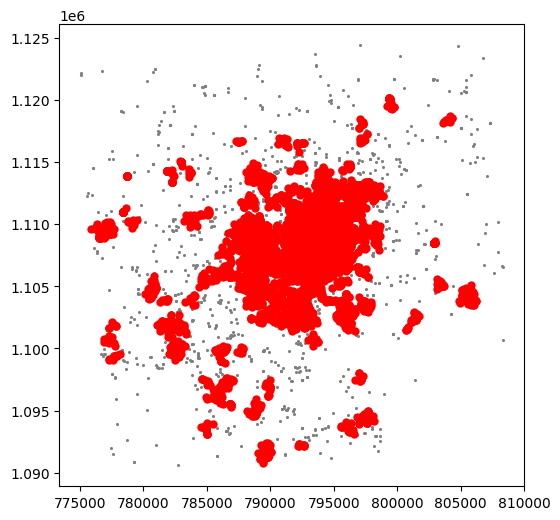

In [56]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Assign labels to tokyo table dynamically and
# subset points that are not part of any cluster (noise)
noise = tokyo.assign(
    lbls=lbls
).query("lbls == -1")
# Plot noise in grey
ax.scatter(
    noise["X_metres"], 
    noise["Y_metres"], 
    c='grey', 
    s=5, 
    linewidth=0
)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    tokyo.loc[tokyo.index.difference(noise.index), "X_metres"], 
    tokyo.loc[tokyo.index.difference(noise.index), "Y_metres"],
    c="red", 
    linewidth=0
)
# Display the figure
plt.show()

The output is now very different, isn't it? This exemplifies how different parameters can give rise to substantially different outcomes, even if the same data and algorithm are applied.

### Advanced plotting

```{Warning}
Please keep in mind this final section of the tutorial is **OPTIONAL**, so do not feel forced to complete it. This will not be covered in the assignment and you will still be able to get a good mark without completing it (also, including any of the following in the assignment does NOT guarantee a better mark).
```

As we have seen, the choice of parameters plays a crucial role in the number, shape and type of clusters founds in a dataset. To allow an easier exploration of these effects, in this section we will turn the computation and visualization of `DBSCAN` outputs into a single function. This in turn will allow us to build an interactive tool later on.

Below is a function that accomplishes just that:

In [57]:
def clusters(db, eps, min_samples):
    '''
    Compute and visualize DBSCAN clusters    
    ...
    
    Arguments
    ---------
    db          : (Geo)DataFrame
                  Table with at least columns `X` and `Y` for point coordinates
    eps         : float
                  Maximum radious to search for points within a cluster
    min_samples : int
                  Minimum number of points in a cluster
    '''
    algo = DBSCAN(eps=eps, min_samples=min_samples)
    algo.fit(db[['X_metres', 'Y_metres']])
    lbls = pd.Series(algo.labels_, index=db.index)

    f, ax = plt.subplots(1, figsize=(6, 6))
    noise = db.loc[lbls==-1, ['X_metres', 'Y_metres']]
    ax.scatter(noise['X_metres'], noise['Y_metres'], c='grey', s=5, linewidth=0)
    ax.scatter(
        db.loc[db.index.difference(noise.index), 'X_metres'],
        db.loc[db.index.difference(noise.index), 'Y_metres'],
        c='red', 
        linewidth=0
    )
    return plt.show()

The function takes the following three arguments:

1. `db`: a `(Geo)DataFrame` containing the points on which we will try to find the clusters.
1. `eps`: a number (maybe with decimals, hence the `float` label in the documentation of the function) specifying the maximum distance to look for neighbors that will be part of a cluster.
1. `min_samples`: a count of the minimum number of points required to form a cluster.

Let us see how the function can be used. For example, let us replicate the plot above, with a minimum of 10 points and a maximum radious of 500 metres:

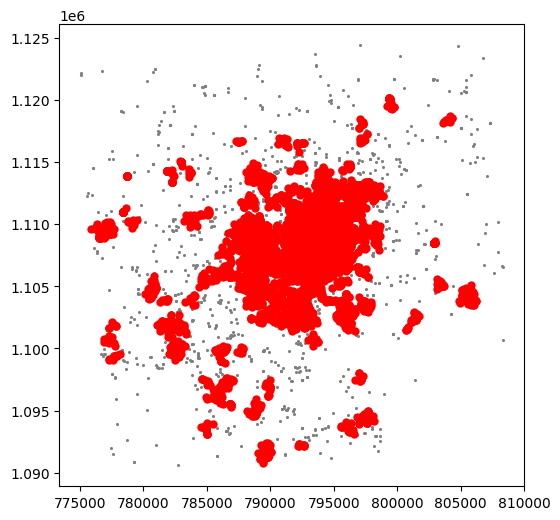

In [58]:
clusters(tokyo, 500, 10)

Voila! With just one line of code, we can create a map of `DBSCAN` clusters. How cool is that? 

However, this could be even more interesting if we didn't have to write each time the parameters we want to explore. To change that, we can create a quick interactive tool that will allow us to modify both parameters with sliders. To do this, we will use the library [`ipywidgets`](https://ipywidgets.readthedocs.io). Let us first do it and then we will analyse it bit by bit:

In [59]:
interact(
    clusters,                 # Method to make interactive
    db=fixed(tokyo),          # Data to pass on db (does not change)
    eps=(50, 500, 50),        # Range start/end/step of eps
    min_samples=(50, 300, 50) # Range start/end/step of min_samples
)

interactive(children=(IntSlider(value=250, description='eps', max=500, min=50, step=50), IntSlider(value=150, …

<function __main__.clusters(db, eps, min_samples)>

Phew! That is cool, isn't it? Once passed the first excitement, let us have a look at how we built it, and how you can modify it further on. A few points on this:

* First, `interact` is a method that allows us to pass an arbitrary function (like `clusters`) and turn it into an interactive widget where we modify the values of its parameters through sliders, drop-down menus, etc.
* What we need to pass to `interact` is the name of the function we would like to make interactive (`clusters` in this case), and all the parameters it will take.
* Since in this case we do not wish to modify the dataset that is used, we pass `tokyo` as the `db` argument in `clusters` and fixate it by passing it first to the `fixed` method.
* Then both the radious `eps` and the minimum cluster size `min_samples` are passed. In this case, we do want to allow interactivity, so we do not use `fixed`. Instead, we pass a tuple that specifies the range and the step of the values we will allow to be used. 
* In the case of `eps`, we use `(50, 500, 50)`, which means we want `r` to go from 50 to 500, in jumps of 50 units at a time. Since these are specified in metres, we are saying we want the range to go from 50 to 500 metres in increments of 50 metres.
* In the case of `min_samples`, we take a similar approach and say we want the minimum number of points to go from 50 to 300, in steps of 50 points at a time.

The above results in a little interactive tool that allows us to play easily and quickly with different values for the parameters and to explore how they affect the final outcome.